# Trade Google With RSI

### __IMPORTANT: This project is 100% done by Max Hong Ka Ho serving as academic study of the stock market and any results in this project should not be treated as investment advices for any individuals__

#### In this project, we would test the myth of technical analysis indicator - RSI in the 10 years Google(GOOG) stock price from 2010 Jan1 to 2020 Jan1 in order to determine its effectiveness in capturing profit during trading of stock

### What is RSI?
#### RSI is an indicator ranging from 0 to 100 indicating the relative strength of the buy and sell side. Its full name is Relative Strength Index
#### Formula of RSI:
#### $RSI = 100RS/(1 + RS)$
#### $RS = UP_t/DOWN_t$
#### where $UP_t and DOWN_t$ are defined as the average increasing magnitude within t periods and average decreasing magnitude within t periods

In [71]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
#define the RSI function first
def rsi(price,period=6):
    closeDif=(price-price.shift(1)).dropna()
    upPrc=pd.Series(0,index=closeDif.index)
    upPrc[closeDif>0]=closeDif[closeDif>0]
    downPrc=pd.Series(0,index=closeDif.index)
    downPrc[closeDif<0]=-closeDif[closeDif<0]
    rsi=[] 
    for i in range(period,len(upPrc)+1):
        up_mean = np.mean(upPrc.values[(i-period):i],\
        dtype=np.float32)
        up_down = np.mean(downPrc.values[(i-period):i],\
        dtype=np.float32)
        rsi.append(100*up_mean/(up_mean+up_down))
    rsi=pd.Series(rsi,index=closeDif.index[(period-1):])
    return(rsi)

In [73]:
#read the stock data
goog = pd.read_csv("GOOG.csv").dropna()
goog.index = pd.to_datetime(goog['Date'])
goog.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-01-04,2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927000
2010-01-05,2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031900
2010-01-06,2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987100
2010-01-07,2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876600
2010-01-08,2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9483900


## First Strategy description
#### we would use the conventional approach to set 20 as oversold signal and 80 as overbought signal with the 14 days RSI as convention. When the RSI values is greater than 80, we would sell the assets. Conversely, if the RSI values break through 20, we would buy the assets until the RSI values go back to 50 level
#### In the first trial, we would use RSI-14 as examples

In [74]:
#useful libraries
def trade(ret_series, signal):
    traderet = ret_series * signal.shift(1)
    traderet = traderet.dropna()
    return traderet

def Sharpe_Ratio(ret_series, rf):
    mean = (1 + ret_series).prod()**(1 / len(ret_series[ret_series != 0])) - 1
    std = np.std(ret_series) * len(ret_series) / len(ret_series[ret_series != 0])
    return (mean - rf) / std
    
def backtest(return_series: pd.Series):
    """
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """ #documetation string
    wealth_index = 10000*(1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth" : wealth_index,
        "Peaks" : previous_peaks,
        "Drawdown" : drawdowns})

In [75]:
#close price of the Google
close = goog.Close
close = close.dropna()
close.head()

Date
2010-01-04    312.204773
2010-01-05    310.829926
2010-01-06    302.994293
2010-01-07    295.940735
2010-01-08    299.885956
Name: Close, dtype: float64

In [76]:
#create rsi14
rsi14 = rsi(close, 14)
rsi14.head()

Date
2010-01-25    16.242505
2010-01-26    18.174004
2010-01-27    20.658144
2010-01-28    21.891138
2010-01-29    14.948422
dtype: float64

In [77]:
#create a dataframe for that
result = pd.DataFrame({'Close': close[rsi14.index],
                       'RSI-14': rsi14}, index = rsi14.index)

In [78]:
result.head()

,Close,RSI-14
Date,,
2010-01-25,268.991760,16.242505
2010-01-26,270.197235,18.174004
2010-01-27,270.037842,20.658144
2010-01-28,266.147400,21.891138
2010-01-29,263.980530,14.948422


In [80]:
#seperate the rsi by level 0, 20, 50, 80, 100
level = (0.0, 20.0, 50.0, 80.0, 100.0)
rsilevel = pd.cut(rsi14, level, labels = False)
rsilevel.head()

Date
2010-01-25    0
2010-01-26    0
2010-01-27    1
2010-01-28    1
2010-01-29    0
dtype: int64

In [81]:
#add to our dataframe
result['RSILevel'] = rsilevel

In [82]:
def tradesig(rsilevel):
    n = len(rsilevel)
    signal = np.zeros(n)
    if rsilevel[0] == 0:
        signal[0] = 1
    elif rsilevel[0] == 3:
        signal[0] = -1
    for i in range(1, n):
        if signal[i - 1] == 1 and (rsilevel[i] == 0 or rsilevel[i] == 1):
            signal[i] = 1
        elif signal[i - 1] == -1 and (rsilevel[i] == 3 or rsilevel[i] == 2):
            signal[i] = -1
        elif signal[i - 1] == 1 and rsilevel[i] >= 2:
            signal[i] = 0
        elif signal[i - 1] == -1 and rsilevel[i]  <= 1:
            signal[i] = 0
        elif signal[i - 1] == 0 and rsilevel[i - 1] > 0 and rsilevel[i] == 0:
            signal[i] = 1
        elif signal[i - 1] == 0 and rsilevel[i - 1] < 3 and rsilevel[i] == 3:
            signal[i] = -1
        
    return signal

In [83]:
#add signal to the df
signal = tradesig(result['RSILevel'])
result['Signal'] = signal
result.head()

,Close,RSI-14,RSILevel,Signal
Date,,,,
2010-01-25,268.991760,16.242505,0,1.0
2010-01-26,270.197235,18.174004,0,1.0
2010-01-27,270.037842,20.658144,1,1.0
2010-01-28,266.147400,21.891138,1,1.0
2010-01-29,263.980530,14.948422,0,1.0


In [107]:
#pick out the position where we buy and sell the stock
Buy_Sig = [1]
Sell_Sig = [0]
for i in range(1, len(result)):
    if result['Signal'][i - 1] < 1 and result['Signal'][i] == 1:
        Buy_Sig.append(1)
    elif result['Signal'][i - 1] == 1 and result['Signal'][i] < 1:
        Buy_Sig.append(-1)
    else:
        Buy_Sig.append(0)
for i in range(1, len(result)):
    if result['Signal'][i - 1] > -1 and result['Signal'][i] == -1:
        Sell_Sig.append(1)
    elif result['Signal'][i - 1] == -1 and result['Signal'][i] > -1:
        Sell_Sig.append(-1)
    else:
        Sell_Sig.append(0)

In [108]:
Buy_Sig

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [109]:
Sell_Sig

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [110]:
#add to the dataframe
result['BuySig'] = Buy_Sig
result['SellSig'] = Sell_Sig
result.head()

,Close,RSI-14,RSILevel,Signal,BuySig,SellSig,Return,TradeReturn
Date,,,,,,,,
2010-01-26,270.197235,18.174004,0,1.0,1,0,0.004481,0.004481
2010-01-27,270.037842,20.658144,1,1.0,0,0,-0.000590,-0.000590
2010-01-28,266.147400,21.891138,1,1.0,0,0,-0.014407,-0.014407
2010-01-29,263.980530,14.948422,0,1.0,0,0,-0.008142,-0.008142
2010-02-01,265.514771,17.573063,0,1.0,0,0,0.005812,0.005812


In [111]:
#create the stock return series
result['Return'] = (result['Close'] - result['Close'].shift(1)) / result['Close'].shift(1)
result.head()

,Close,RSI-14,RSILevel,Signal,BuySig,SellSig,Return,TradeReturn
Date,,,,,,,,
2010-01-26,270.197235,18.174004,0,1.0,1,0,NaN,0.004481
2010-01-27,270.037842,20.658144,1,1.0,0,0,-0.000590,-0.000590
2010-01-28,266.147400,21.891138,1,1.0,0,0,-0.014407,-0.014407
2010-01-29,263.980530,14.948422,0,1.0,0,0,-0.008142,-0.008142
2010-02-01,265.514771,17.573063,0,1.0,0,0,0.005812,0.005812


In [112]:
#trade it with rsi signal
result['TradeReturn'] = trade(result['Return'], result['Signal'])
result['TradeReturn'][result['TradeReturn'] == -0.0] = 0
result.head(5)

C:\Users\Hp User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,RSI-14,RSILevel,Signal,BuySig,SellSig,Return,TradeReturn
Date,,,,,,,,
2010-01-26,270.197235,18.174004,0,1.0,1,0,NaN,NaN
2010-01-27,270.037842,20.658144,1,1.0,0,0,-0.000590,-0.000590
2010-01-28,266.147400,21.891138,1,1.0,0,0,-0.014407,-0.014407
2010-01-29,263.980530,14.948422,0,1.0,0,0,-0.008142,-0.008142
2010-02-01,265.514771,17.573063,0,1.0,0,0,0.005812,0.005812


In [113]:
#remove nan terms
result = result.dropna()
result.head()

,Close,RSI-14,RSILevel,Signal,BuySig,SellSig,Return,TradeReturn
Date,,,,,,,,
2010-01-27,270.037842,20.658144,1,1.0,0,0,-0.000590,-0.000590
2010-01-28,266.147400,21.891138,1,1.0,0,0,-0.014407,-0.014407
2010-01-29,263.980530,14.948422,0,1.0,0,0,-0.008142,-0.008142
2010-02-01,265.514771,17.573063,0,1.0,0,0,0.005812,0.005812
2010-02-02,264.568329,19.166795,0,1.0,0,0,-0.003565,-0.003565


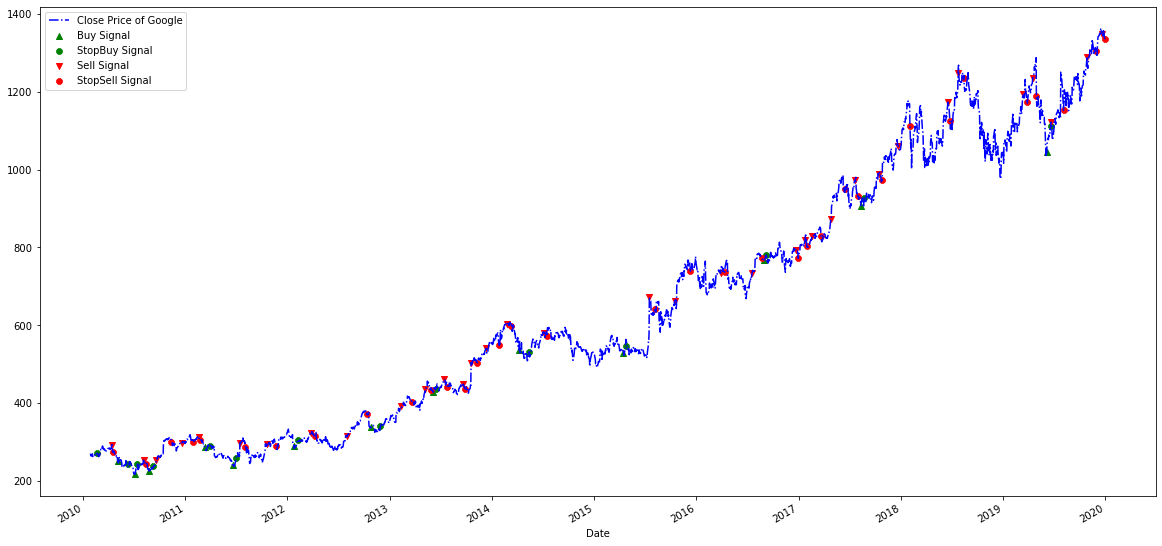

In [115]:
#create the backtest result
trade_result = backtest(result['TradeReturn'])
stock_result = backtest(result['Return'])
result['Close'].plot(figsize = (20, 10), color = 'b', linestyle = '-.', label = 'Close Price of Google')
plt.scatter(result['BuySig'][result['BuySig'] == 1].index, result['Close'][result['BuySig'] == 1], marker = '^', color = 'g', label = 'Buy Signal')
plt.scatter(result['BuySig'][result['BuySig'] == -1].index, result['Close'][result['BuySig'] == -1], marker = '8', color = 'g', label = 'StopBuy Signal')
plt.scatter(result['SellSig'][result['SellSig'] == 1].index, result['Close'][result['SellSig'] == 1], marker = 'v', color = 'r', label = 'Sell Signal')
plt.scatter(result['SellSig'][result['SellSig'] == -1].index, result['Close'][result['SellSig'] == -1], marker = '8', color = 'r', label = 'StopSell Signal')
plt.legend()

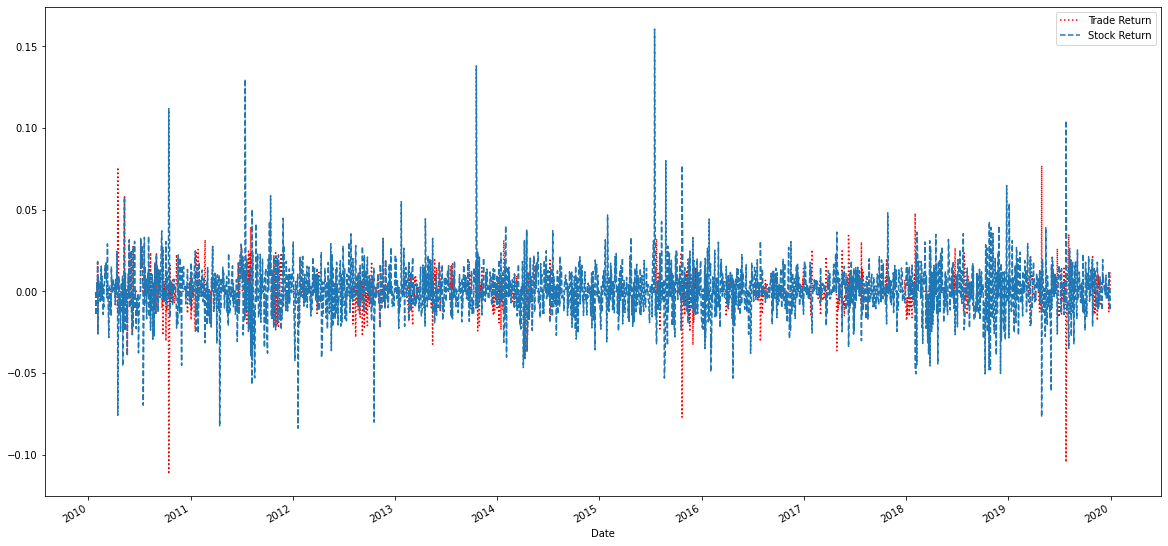

In [116]:
#compare the trade return and stock return
result['TradeReturn'].plot(figsize = (20,10), color = 'r', linestyle = ':', label = 'Trade Return')
result['Return'].plot(linestyle = '--', label = 'Stock Return')
plt.legend()

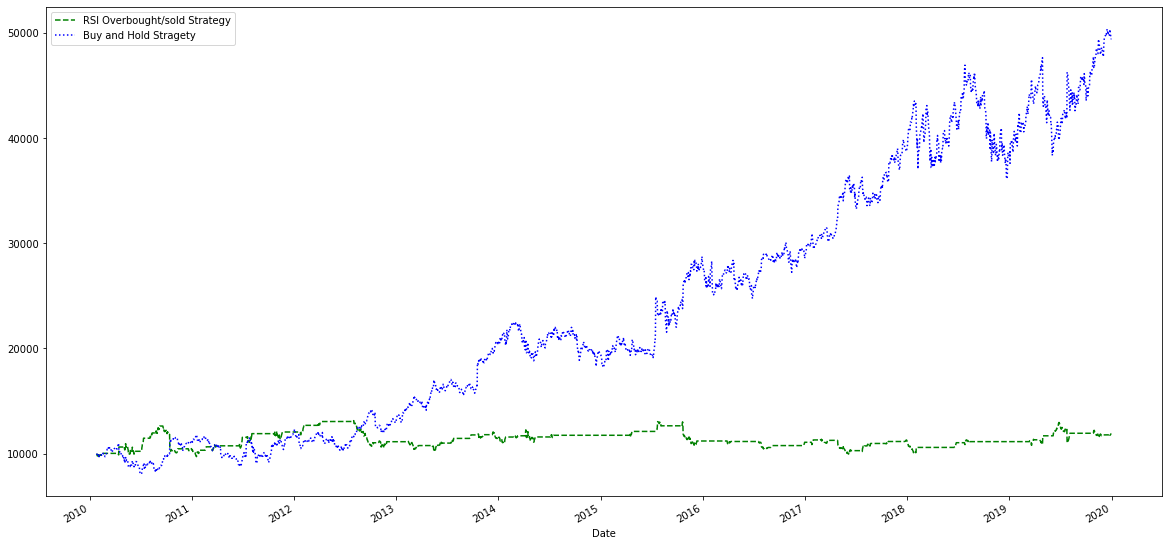

In [118]:
#take a look at the backtest result
trade_result['Wealth'].plot(figsize = (20, 10), color = 'g', linestyle = '--', label = 'RSI Overbought/sold Strategy')
stock_result['Wealth'].plot(color = 'b', linestyle = ':', label = 'Buy and Hold Stragety')
plt.legend()

### It is no wonder that the traditional RSI overbuy/sell strategy doesn't give us any edge at all

In [258]:
#return of the rsi14 strategy
returns = trade_result['Wealth'][-1] / trade_result['Wealth'][0] - 1
#return of stock
stock_ret = stock_result['Wealth'][-1] / stock_result['Wealth'][0] - 1
returns, stock_ret

(0.18906904775268774, 3.9512320573203157)

C:\Users\Hp User\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


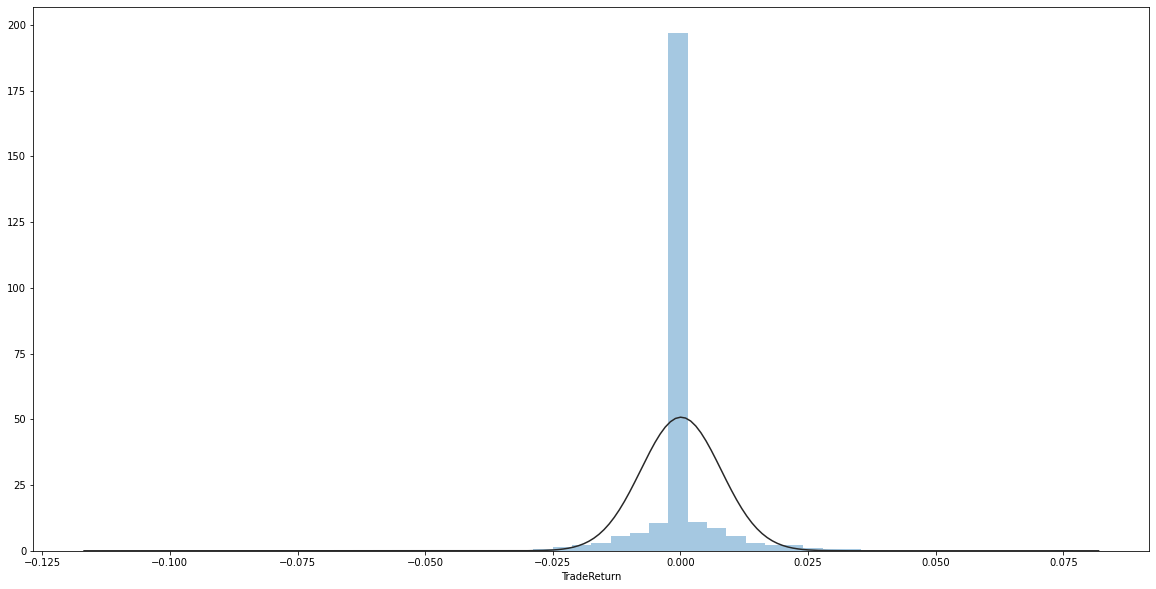

In [150]:
#look at the hist return graph
from scipy import stats
plt.figure(figsize = (20, 10))
sns.distplot(result['TradeReturn'], fit = stats.norm)

### With 10 years of trading , the RSI overbuy/oversell strategy gives us 18% return in total

In [121]:
#average win
meanwin = result['TradeReturn'][result['TradeReturn'] >= 0].mean()
meanwin

0.0017801251897100565

In [126]:
#average loss
meanloss = -result['TradeReturn'][result['TradeReturn'] < 0].mean()
meanloss

0.009602043676685887

In [125]:
#probability to win
accuracy = len(result['TradeReturn'][result['TradeReturn'] > 0]) / len(result['TradeReturn'][result['TradeReturn'] != 0])
accuracy

0.515748031496063

In [128]:
#expected value
ev = accuracy * meanwin - (1 - accuracy) *meanloss
ev

-0.0037317124896864046

In [132]:
#sharpe ratio assuming 0 rf
sp = Sharpe_Ratio(result['TradeReturn'], 0)
#sharpe ratio of stock
stock_sp = Sharpe_Ratio(result['Return'], 0)
sp, stock_sp

(0.008793752927919608, 0.04164092146682037)

In [134]:
#maxdd
maxdd = trade_result['Drawdown'].min()
maxdd

-0.2426365897144021

#### The RSI strategy will give us negative expected value in the long run that implies that we should not solely trade by overbuy/sell without taking reference on other trading strategies. Besides, the sharpe ratio is substantially smaller that the stock itself, which indicates the ineffectiveness of the RSI indicator

## Find the optimal Parameter
#### now we would optimize the parameter to see if the best parameter can outperform the market or not

In [227]:
rsi_list = []
meanwin_list = []
meanloss_list = []
ev_list = []
sr_list = []
acc_list = []
act_ret_list = []
maxdd_list = []
returns = close / close.shift(1) - 1
level = (0.0, 20.0, 50.0, 80.0, 100.0)
#run 2 - 50 cases
for i in range(2,51):
    rsi_list.append(i)
    rsi_series = rsi(close, i)
    rsilevel = pd.cut(rsi_series, level, labels = False)
    trade_signal = tradesig(rsilevel)
    trade_signal = pd.Series(trade_signal, index = rsilevel.index)
    trade_return = trade(returns[rsi_series.index], trade_signal)
    meanwin = trade_return[trade_return > 0].mean()
    meanwin_list.append(meanwin)
    meanloss = -trade_return[trade_return < 0].mean()
    meanloss_list.append(meanloss)
    trade_return[trade_return == -0.0] = 0
    accuracy = len(trade_return[trade_return > 0]) / len(trade_return[trade_return != 0])
    acc_list.append(accuracy)
    ev = accuracy * meanwin - (1 - accuracy) *meanloss
    ev_list.append(ev)
    sp = Sharpe_Ratio(trade_return, 0)
    sr_list.append(sp)
    btresult = backtest(trade_return)
    actual_ret = btresult['Wealth'][-1] / btresult['Wealth'][0] - 1
    act_ret_list.append(actual_ret)
    maxdd = btresult['Drawdown'].min()
    maxdd_list.append(maxdd)

In [228]:
rsi_list = np.array(rsi_list)
rsi_list

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [229]:
meanwin_list = np.array(meanwin_list)
meanwin_list

array([0.00982022, 0.00954468, 0.00949593, 0.01012585, 0.01053131,
       0.01019327, 0.010289  , 0.01041805, 0.01012536, 0.00954523,
       0.00961347, 0.00951365, 0.00963941, 0.0095229 , 0.0097391 ,
       0.00961038, 0.0099392 , 0.00981997, 0.009792  , 0.0098694 ,
       0.01032674, 0.00889182, 0.00946673, 0.01088733, 0.01145195,
       0.01007252, 0.01032585, 0.01026584, 0.01019606, 0.01056657,
       0.0109765 , 0.01066903, 0.01150794, 0.01166717, 0.01173519,
       0.01258733, 0.01010618, 0.01613533, 0.01237574, 0.01234005,
       0.01203398, 0.01203398, 0.01169606, 0.01198064, 0.01190697,
       0.01151976, 0.01099113, 0.01068247, 0.01068247])

In [230]:
meanloss_list = np.array(meanloss_list)
meanloss_list

array([0.01007779, 0.01037619, 0.01057165, 0.01019102, 0.00995329,
       0.01039667, 0.01063862, 0.01085337, 0.01109183, 0.01053586,
       0.01074931, 0.01018457, 0.00960204, 0.0094774 , 0.00914037,
       0.00909351, 0.00921676, 0.00895755, 0.00891568, 0.00978742,
       0.00930375, 0.00923196, 0.0095078 , 0.00926158, 0.00918499,
       0.00937376, 0.0101915 , 0.0102458 , 0.00874365, 0.00869957,
       0.00734426, 0.00671615, 0.0078033 , 0.00794429, 0.00799431,
       0.0078698 , 0.00722726, 0.00781674, 0.00742174, 0.00640645,
       0.00665754, 0.00647151, 0.00725302, 0.00733648, 0.00696645,
       0.00753156, 0.00748473, 0.00753156, 0.0078779 ])

In [231]:
ev_list = np.array(ev_list)
ev_list

array([-1.14641180e-03, -9.60599830e-04, -6.22959297e-04,  8.78113038e-05,
        7.09490225e-04,  1.93886205e-04,  3.97222769e-04,  1.01609384e-04,
        1.01860183e-05, -1.46341223e-04, -2.97244687e-04,  1.54568793e-05,
        3.33911035e-04,  1.83275747e-04,  5.95991290e-04,  3.56532594e-04,
        4.72591274e-04,  2.80816990e-04,  2.86943466e-04, -1.73838611e-04,
        6.87055894e-05, -4.84965612e-04, -3.42141735e-04,  3.93105274e-04,
        8.33775133e-04,  3.49383032e-04, -7.20856585e-05, -3.76785194e-05,
       -1.22814786e-04,  5.62997767e-04,  1.31646172e-03,  1.70048689e-03,
        1.29257136e-03,  1.28462815e-03,  1.40069175e-03,  1.75708489e-03,
        1.14060646e-03,  3.96296997e-03,  1.57711423e-03,  6.86820385e-04,
        9.20103791e-04,  1.03071613e-03,  1.91589325e-03,  1.84706870e-03,
        4.83581663e-04,  8.73433293e-04,  7.26764755e-04,  1.06950956e-03,
        1.13713751e-03])

In [232]:
acc_list = np.array(acc_list)
acc_list

array([0.44885799, 0.47264957, 0.49575944, 0.50592593, 0.52052672,
       0.51435603, 0.52733389, 0.51500938, 0.52325581, 0.51737835,
       0.51329243, 0.51781473, 0.5163827 , 0.50844854, 0.51571165,
       0.50524476, 0.50581395, 0.49199085, 0.49191686, 0.48907104,
       0.47744361, 0.48262548, 0.48305085, 0.47916667, 0.48547718,
       0.5       , 0.49321267, 0.49767442, 0.45517241, 0.48076923,
       0.47272727, 0.48412698, 0.47101449, 0.47058824, 0.47619048,
       0.47058824, 0.48275862, 0.49180328, 0.45454545, 0.37837838,
       0.40540541, 0.40540541, 0.48387097, 0.47540984, 0.39473684,
       0.44117647, 0.44444444, 0.47222222, 0.48571429])

In [233]:
sr_list = np.array(sr_list)
sr_list

array([-0.0519758 , -0.04791146, -0.03490785, -0.00159412,  0.02679411,
        0.00277346,  0.01163394, -0.00147379, -0.0049597 , -0.01100912,
       -0.01678278, -0.00379683,  0.00901925,  0.00273653,  0.01619142,
        0.00856868,  0.01144296,  0.00507925,  0.0052076 , -0.00728525,
       -0.00120079, -0.01313196, -0.00927865,  0.00486153,  0.01284345,
        0.00435538, -0.00381321, -0.00317068, -0.00381545,  0.00656475,
        0.02284652,  0.02862143,  0.01933752,  0.01888892,  0.01939156,
        0.02318102,  0.01717465,  0.03521568,  0.0169213 ,  0.00600255,
        0.00824948,  0.00936902,  0.02292236,  0.02167103,  0.00402047,
        0.00709271,  0.00612441,  0.00938615,  0.00973209])

In [234]:
act_ret_list = np.array(act_ret_list)
act_ret_list

array([-0.72097335, -0.71790592, -0.6173085 , -0.02716982,  1.14097597,
        0.07560121,  0.39992708, -0.05150008, -0.12250051, -0.23721926,
       -0.34130736, -0.06187338,  0.1883676 ,  0.05242313,  0.32600098,
        0.16654901,  0.20120315,  0.08369443,  0.06231385, -0.10139158,
       -0.01545676, -0.14206086, -0.10275397,  0.06377094,  0.18171715,
        0.05240757, -0.04628914, -0.03835088, -0.03654396,  0.06904328,
        0.22356847,  0.22645626,  0.17834797,  0.17400552,  0.14694535,
        0.18373017,  0.09781053,  0.2623987 ,  0.08549299,  0.02283656,
        0.03167296,  0.03592279,  0.12056597,  0.11372453,  0.01554257,
        0.02718785,  0.02353785,  0.03625093,  0.03759718])

In [235]:
maxdd_list = np.array(maxdd_list)
maxdd_list

array([-0.81340879, -0.80120198, -0.69964809, -0.47302225, -0.35284325,
       -0.46189553, -0.36782236, -0.40981194, -0.47950619, -0.52175561,
       -0.48439167, -0.29910646, -0.24263659, -0.26313623, -0.22425088,
       -0.25322631, -0.25014554, -0.21793199, -0.23287896, -0.30270574,
       -0.24821537, -0.24618317, -0.20084724, -0.17912417, -0.16621758,
       -0.21412734, -0.217296  , -0.21651521, -0.19683661, -0.16088219,
       -0.13669799, -0.06901431, -0.13404723, -0.14214757, -0.10395224,
       -0.10623912, -0.07662628, -0.06236224, -0.06617796, -0.06663343,
       -0.06663343, -0.06663343, -0.07214935, -0.07463894, -0.08323358,
       -0.08323358, -0.08323358, -0.08323358, -0.08323358])

In [236]:
#put them into a dataframe
Backtest_Table = pd.DataFrame({'Mean Win': meanwin_list,
                               'Mean Loss': meanloss_list,
                               'Expected Value': ev_list,
                               'Accuracy': acc_list,
                               'Sharpe Ratio': sr_list, 
                               'Max DrawDown':maxdd_list,
                               'Actual Return': act_ret_list},
                              index = rsi_list)
#index corresponds to the corresponding parameter
Backtest_Table.index.name = 'RSI Period'
Backtest_Table

,Mean Win,Mean Loss,Expected Value,Accuracy,Sharpe Ratio,Max DrawDown,Actual Return
RSI Period,,,,,,,
2,0.009820,0.010078,-0.001146,0.448858,-0.051976,-0.813409,-0.720973
3,0.009545,0.010376,-0.000961,0.472650,-0.047911,-0.801202,-0.717906
4,0.009496,0.010572,-0.000623,0.495759,-0.034908,-0.699648,-0.617308
5,0.010126,0.010191,0.000088,0.505926,-0.001594,-0.473022,-0.027170
6,0.010531,0.009953,0.000709,0.520527,0.026794,-0.352843,1.140976
7,0.010193,0.010397,0.000194,0.514356,0.002773,-0.461896,0.075601
8,0.010289,0.010639,0.000397,0.527334,0.011634,-0.367822,0.399927
9,0.010418,0.010853,0.000102,0.515009,-0.001474,-0.409812,-0.051500
10,0.010125,0.011092,0.000010,0.523256,-0.004960,-0.479506,-0.122501


In [244]:
#get the max ev
index = np.where(ev_list == max(ev_list))[0][0]
index

37

In [245]:
#get the max sharpe ratio
index1 = np.where(sr_list == max(sr_list))[0][0]
index1

37

In [246]:
#get highest accuracy
index2 = np.where(acc_list == max(acc_list))[0][0]
index2

6

In [247]:
#min max dd
index3 = np.where(maxdd_list == min(maxdd_list))[0][0]
index3

0

In [248]:
#max actual return
index4 = np.where(act_ret_list == max(act_ret_list))[0][0]
index4

4

In [251]:
#look at the particular column
Backtest_Table.iloc[[0,4,6,37]]

,Mean Win,Mean Loss,Expected Value,Accuracy,Sharpe Ratio,Max DrawDown,Actual Return
RSI Period,,,,,,,
2,0.009820,0.010078,-0.001146,0.448858,-0.051976,-0.813409,-0.720973
6,0.010531,0.009953,0.000709,0.520527,0.026794,-0.352843,1.140976
8,0.010289,0.010639,0.000397,0.527334,0.011634,-0.367822,0.399927
39,0.016135,0.007817,0.003963,0.491803,0.035216,-0.062362,0.262399


#### After our rigorous backtest, we find that period = 2 gives us the minimum max DD, period = 6 gives largest biggest return, period = 8 gives highest accuracy and period = 39 gives maximum expected value and sharpe ratio

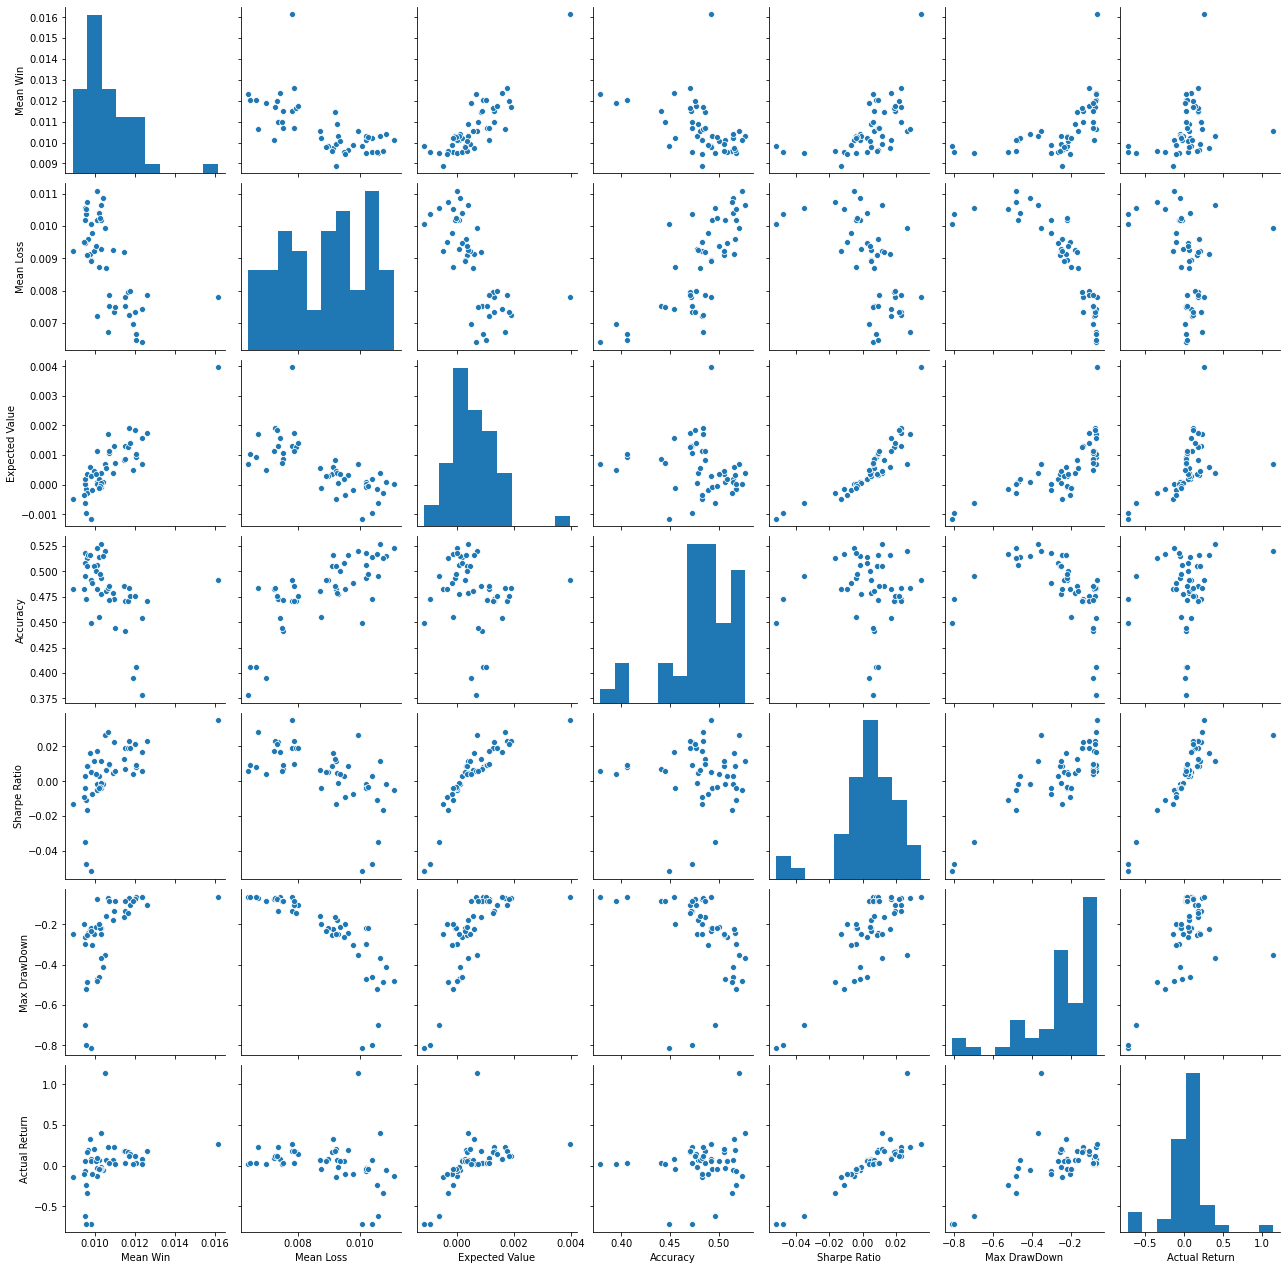

In [257]:
#take a look at all their relations
sns.pairplot(Backtest_Table)

## Conclusion
### Neither one of the best parameter can beat the stock return and It again shows how fallible all the indicators are. Next time, we would work on more indicators to have a look if they work or not